# CPM Routing Optimization

# Load up the data 
* Demands = number of unpaid + expired
* locations = x,y coordinates of block
* labels = block id
* cars = average number of cars

## Data is from March 2017 to March 2018

In [137]:
import csv
demands = []
labels = []
locations = []
firstLine = True
limiter = 9999999
counter = 0
cars = []
megaCluster = []
with open('Routing Data_2_031518_XY_MegaCluster.csv', 'rb') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if counter < limiter: #this is just a cap to QA the model with fewer locations
            if firstLine:
                firstLine = False
            else:
                latLong = []
                latLong.append(float(row[21]))
                latLong.append(float(row[22]))
                locations.append(latLong)
                labels.append(row[1])
                demands.append(float(row[24]))
                cars.append(float(row[25]))
                megaCluster.append(int(row[23]))
                counter+=1


start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)
zone = [int(x[4]) for x in labels]
np.bincount(np.array(zone))

array([   0, 1401,  456,  383,  662,  130,  685,  228,   15,   68])

In [138]:
import pandas as pd
dictionary = {'Block ID': labels, 'Unpaid and Expired Average': demands, 'Locations': locations}

df = pd.DataFrame.from_dict(dictionary)
df.head()

,Block ID,Locations,Unpaid and Expired Average
0,B101101,"[444454.5456, 4649832.168]",1.545455
1,B200401,"[446463.1853, 4637775.894]",0.732456
2,B200403,"[446316.7979, 4637773.449]",0.299539
3,B200405,"[446344.811, 4637777.506]",0.217593
4,B200406,"[446488.1358, 4637779.476]",0.327189


# Next step - find optimal clusters of blocks for car drop-off
## Plotting locations below

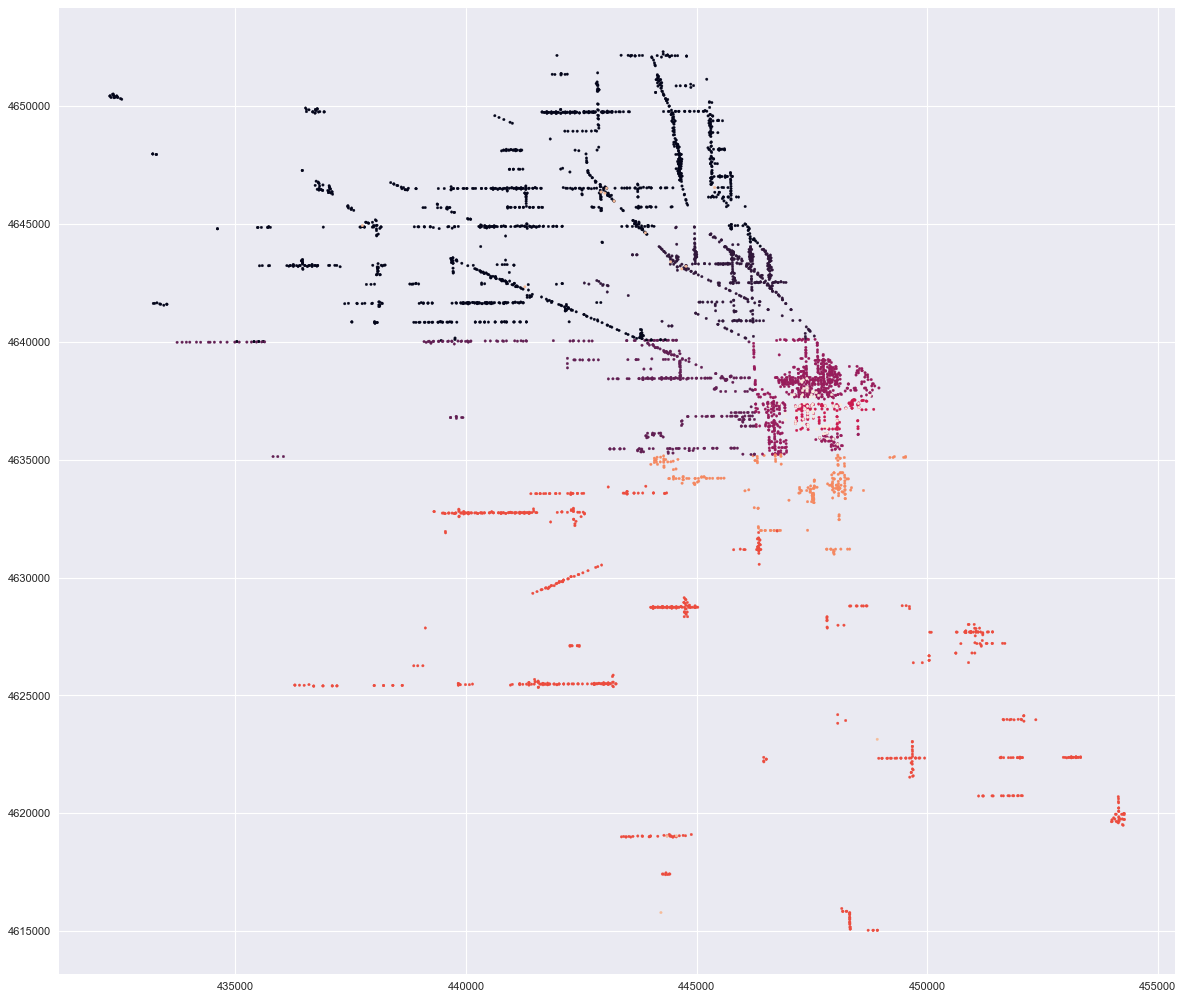

In [139]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
seed = 1234 # setting seed to keep results the same run to run
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter([x[0] for x in locations], [x[1] for x in locations], s=5, c=zone)
# plt.figure(figsize=(200,100))

# Below we are trying to find the optimal number of clusters. 
This is found by iterating through clusters 1-50 and looking at the average number of blocks + the average distance of blocks from the center starting point of the cluster.

# UPDATE 3.14.18:

K means had some overlapping clusters - now moving to a density based cluster to get the clusters to make more sense geographically

Cluster Sizes: [1160   63   94   97   68  129  183   63   98  418  536  100  134  885]


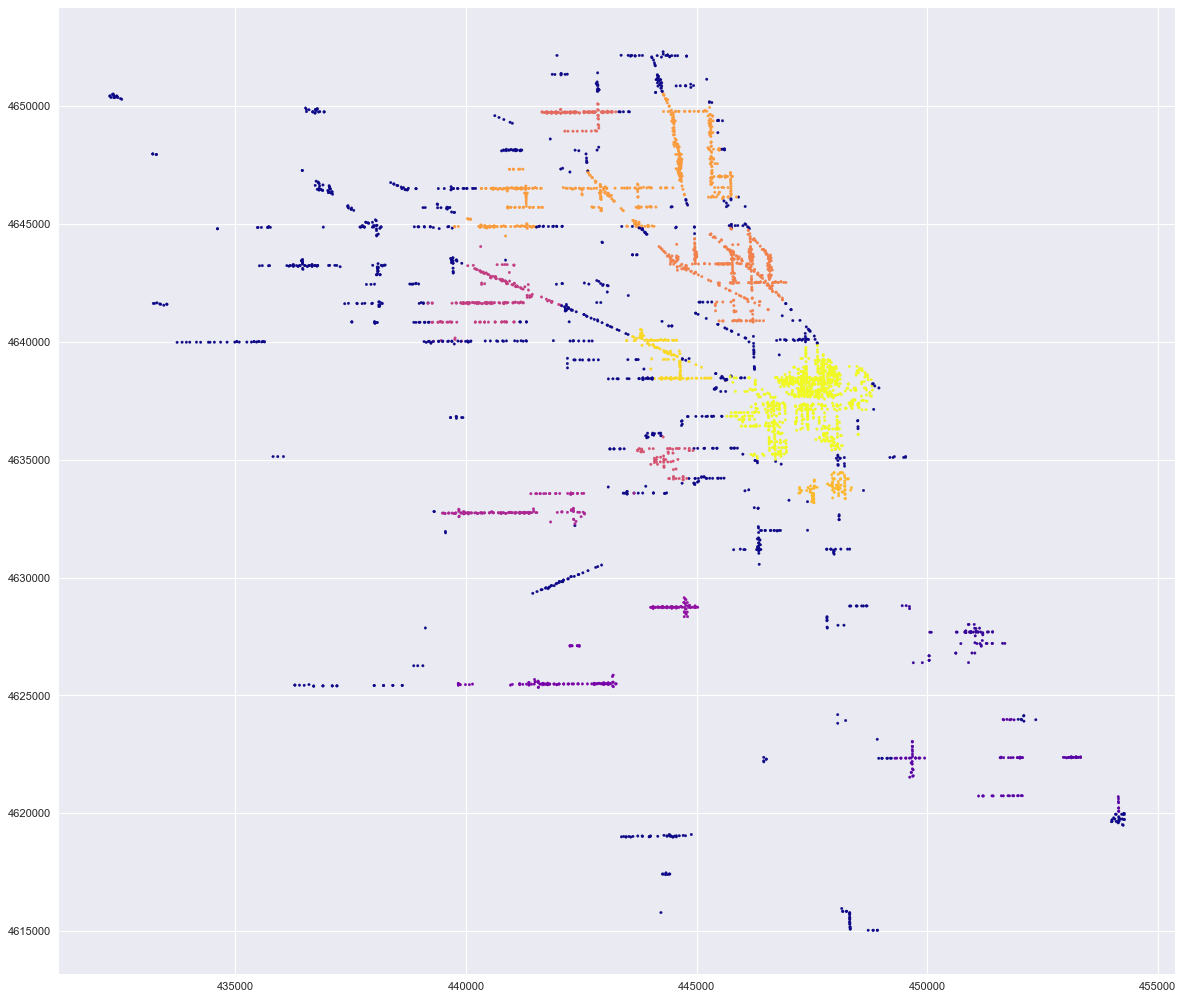

In [179]:
# Elbow chart
from scipy.cluster.vq import vq
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import hdbscan


X = np.array(zip([x[0] for x in locations],[x[1] for x in locations]))

clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
cluster_labels = clusterer.fit_predict(X)

hdbscanLabels = cluster_labels + 100 #IDS will be incremented by 100 - note that 99 aka -1 will use kmeans
cSizes = np.bincount(cluster_labels + 1)
print("Cluster Sizes: " + str(cSizes))

#need to find centroid of HDSCAN clusters

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

XX = np.column_stack((X, cluster_labels))
centers = []
for k in range(len(cSizes) - 1):
    ind = np.where(XX[:, 2] == k)
    locs = XX[ind, 0:1]
    cent = centeroidnp(locs)
    centers.append(cent)
centers = np.array(centers)
denseCenters = centers # save as another object
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, s=5, cmap='plasma')

# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5)

# Using the idea of downtown 'mega-cluster' where individuals walk from the LAZ garage

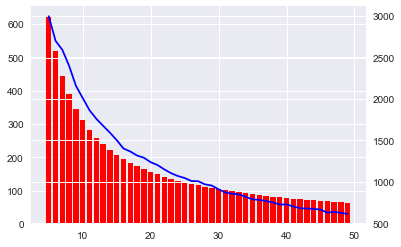

In [143]:
# omit from megacluster to find ideal clusters
mc = np.array(megaCluster)
distortions = []
avgBinsize = []
indexes = np.where(np.array(mc)[:] == 0)
Xzone = X[indexes]
K = range(5,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=seed).fit(Xzone)
    kmeanModel.fit(Xzone)
    distortions.append(sum(np.min(cdist(Xzone, kmeanModel.cluster_centers_, 'euclidean'), axis=1))/ Xzone.shape[0])
    centers = kmeanModel.cluster_centers_
    idx,_ = vq(Xzone,centers) #finding the number of blocks by cluster
    avgBinsize.append(np.average(np.bincount(idx)))
plt.bar(K, avgBinsize, color='r')
# for kb in zip(K,avgBinsize):|
#     plt.annotate('{}'.format(kb), xy=kb, textcoords='data')
axes2 = plt.twinx()
# print("Zone # {}".format(i))
plt.plot(K, distortions, 'bx-')
plt.show()
i+=1
# print(zip(K,avgBinsize, distortions))


# Now we are choosing the number of clusters and slicing the data by cluster
## kData is the data structure that will be used to hold the data by cluster, and eventually the solution
* center = the x,y coord that is the center of the cluster
* locations = the locations by cluster
* labels = block id by cluster
* cars = number of parked cars by cluster
* demand = number of unpaid + expired by cluster
* centralTerm = the blockID closest to the center

Cluster Sizes: [  0 294 102 152 147  78 140  98 198  25 158  79 140 343  39  64 193  97
  36  37 165  26  66  98 140 196]


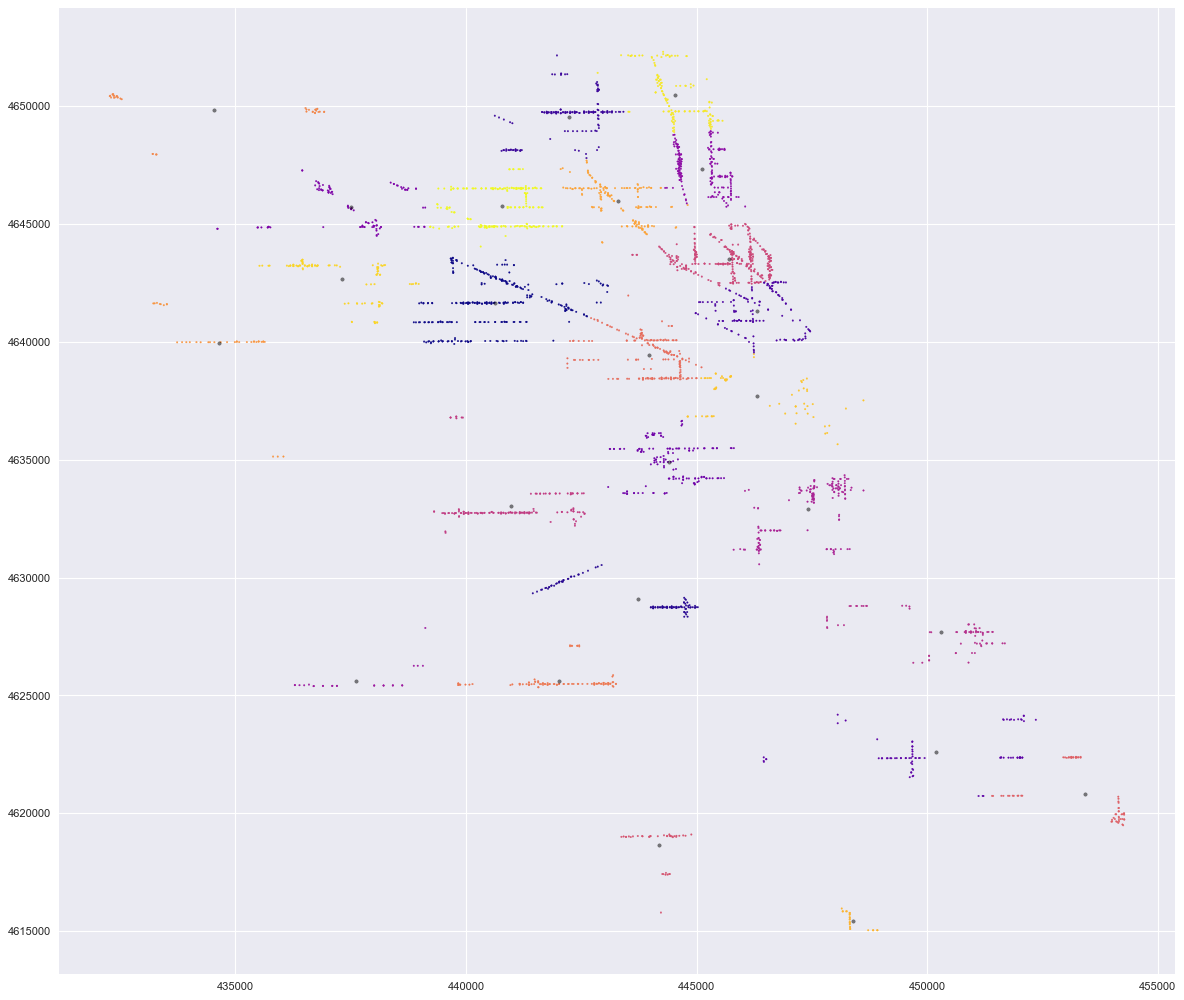

In [180]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
seed = 1234
X = np.array(zip([x[0] for x in locations],[x[1] for x in locations]))

fullData = {'locations': locations, 'labels': labels, 'cars': cars, 'demands': demands, 'megacluster': megaCluster}

fullDS = pd.DataFrame.from_dict(fullData)


nClusters = 25

kData ={key: {'center': None, 'locations': None, 'labels' : None, 'cars' : None, 'demand' : None,\
              'centralTerm': None} for key in range(nClusters)}

#now load up the megacluster first:

megaData = fullDS.loc[fullDS['megacluster'] == 1]
nonmegaData = fullDS.loc[fullDS['megacluster'] == 0]

megaDict = megaData.to_dict(orient='list')
nonMegaDict = nonmegaData.to_dict(orient='list')

X = np.array(zip([x[0] for x in nonMegaDict['locations']],[x[1] for x in nonMegaDict['locations']]))

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

kmeans = KMeans(n_clusters=nClusters, random_state=seed)
kmeans.fit(X)

kPred = kmeans.predict(X)

plt.scatter(X[:, 0], X[:, 1], c=kPred, s=2, cmap='plasma')


centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=10, alpha=0.5)

# print np.average(np.bincount(idx))
closest, _ = pairwise_distances_argmin_min(centers, X)
centerTerminals = [labels[c] for c in closest]
kData ={key: {'center': None, 'locations': None, 'labels' : None, 'cars' : None, 'demand' : None,\
              'centralTerm': None} for key in range(nClusters)}
# kData = {}
for k in range(nClusters):
    klocations = []
    klabels = []
    kcars = []
    kdemand = []
    for loc, lab, car, dem, kp in zip(nonMegaDict['locations'], nonMegaDict['labels'],\
                                      nonMegaDict['cars'], nonMegaDict['demands'], kPred):
        if kp == k:
            klocations.append(loc)
            klabels.append(lab)
            kcars.append(car)
            kdemand.append(dem)
#     print(len(klocations))
kData.update({nClusters  : {'center':centers[k], 'locations': megaDict['locations'], 
                 'labels': megaDict['labels'], 'cars' : megaData['cars'], 'demand': megaData['demands'],\
                             'centralTerm' : "LAZ GARAGE"}})
            
# kData[0]

#add megacluster 

            
cSizes = np.bincount(kPred + 1)
print("Cluster Sizes: " + str(cSizes))
# centers

In [181]:
#save cluster data to csv
import datetime
import pandas as pd
now = datetime.datetime.now()

filename = "clusterFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv"

nonmegaData["clusterID"] = kPred.tolist()
megaData["clusterID"] = [nClusters ] * len(megaData)

df = nonmegaData.append(megaData)
# se = pd.Series(kPred)
# se2 = pd.Series(cluster_labels)
# df = pd.DataFrame(np.column_stack((kPred, hdbscanLabels, np.array(labels))), columns=["kMeans", "HDBScan", "Block ID"])
# df

df.to_csv(filename)

/Users/jwortz/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jwortz/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


# Create objects and callback functions for optimization algorithm
* distance = manhattan distance function
* distanceCallback = distance function from previous to current block
* demandCallback = get the paid + unpaid for the current block
* ServiceTimeCallback = get the time per ticket written
* CarCheckCallback = get the time it takes to check each indivisual car
* travelTimeCallback = get the travel time from node to node assuming a speed
* totalTimeCallback = the total time for the block, adding the various time callbacks + block overhead time assumptions

In [176]:
import math
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

def distance(x1, y1, x2, y2):
    # Manhattan distance
    dist = abs(x1 - x2) + abs(y1 - y2)

    return dist

# Distance callback

class CreateDistanceCallback(object):
  """Create callback to calculate distances and travel times between points."""

  def __init__(self, locations):
    """Initialize distance array."""
    num_locations = len(locations)
    self.matrix = {}

    for from_node in xrange(num_locations):
      self.matrix[from_node] = {}
      for to_node in xrange(num_locations):
#             JSW: THIS ALLOWS O TRAVEL PENALTY FROM DEPOT
#         if from_node == depot or to_node == depot:
#           self.matrix[from_node][to_node] = 0
#         else:
          x1 = locations[from_node][0]
          y1 = locations[from_node][1]
          x2 = locations[to_node][0]
          y2 = locations[to_node][1]
          self.matrix[from_node][to_node] = distance(x1, y1, x2, y2)

  def Distance(self, from_node, to_node):
     return self.matrix[from_node][to_node]


# Demand callback
class CreateDemandCallback(object):
  """Create callback to get demands at location node."""

  def __init__(self, demands):
    self.matrix = demands

  def Demand(self, from_node, to_node):
    return self.matrix[from_node]

# Service time (proportional to demand) callback.
class CreateServiceTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, demands, time_per_demand_unit):
    self.matrix = demands
    self.time_per_demand_unit = time_per_demand_unit

  def ServiceTime(self, from_node, to_node):
#     return int(self.matrix[from_node] * self.time_per_demand_unit)
    return self.matrix[from_node] * self.time_per_demand_unit

######JSW ADD BLOCK OVERHEAD TIME

class CreateBlockOverheadTime(object):
  """Create callback to get overhead time for each block."""

  def __init__(self, overhead_time):
    self.matrix = demands
    self.overhead_time = overhead_time

  def BlockOverheadTime(self, from_node, to_node):
    return int(self.overhead_time)


####################

######JSW ADD NONVIOLATOR CHECK TIME
# Service time (proportional to demand) callback.
class CreateCarCheckTimeCallback(object):
  """Create callback to get time windows at each location."""

  def __init__(self, cars, time_per_car_unit):
    self.matrix = cars
    self.time_per_car_unit = time_per_car_unit

  def ServiceTime(self, from_node, to_node):
    return int(self.matrix[from_node] * self.time_per_car_unit)
#####################################

# Create the travel time callback (equals distance divided by speed).
class CreateTravelTimeCallback(object):
  """Create callback to get travel times between locations."""

  def __init__(self, dist_callback, speed):
    self.dist_callback = dist_callback
    self.speed = speed

  def TravelTime(self, from_node, to_node):
    travel_time = self.dist_callback(from_node, to_node) / self.speed
    return int(travel_time)
# Create total_time callback (equals service time plus travel time).
class CreateTotalTimeCallback(object):
  """Create callback to get total times between locations."""

  def __init__(self, service_time_callback, travel_time_callback, car_check_time_callback, \
              overhead_time_callback):
    self.service_time_callback = service_time_callback
    self.travel_time_callback = travel_time_callback
    self.car_check_time_callback = car_check_time_callback
    self.overhead_time_callback = overhead_time_callback

  def TotalTime(self, from_node, to_node):
    service_time = self.service_time_callback(from_node, to_node)
    travel_time = self.travel_time_callback(from_node, to_node)
    car_check_time = self.car_check_time_callback(from_node, to_node)
    overhead_time = self.overhead_time_callback(from_node, to_node)
    return service_time + travel_time + car_check_time + overhead_time

def get_routes_array(assignment, num_routes, routing):
  # Get the routes for an assignent and return as a list of lists.
  routes = []
  for route_nbr in range(num_routes):
    node = routing.Start(route_nbr)
    route = []

    while not routing.IsEnd(node):
      node = assignment.Value(routing.NextVar(node))
      route.append(node)
    routes.append(route)
  return routes

In [177]:
#creating objects for function to work below
depot = 0
labs = ['a','b']

# Below is the optimization algorithm and function
## key parameters:
* locations = list of locations
* demands = paid + unpaid
* start times, end times = the time windows of a given block's availability... currently not used
* num_vehicles = number of enforcement agents
* search time limit = limit in ms of time to find a solution
* time per demand unit = time it takes to write a ticket
* speed = walking speed between blocks
* vehicle capacity = maximum tickets that can be written - not used aka: unlimited
* depot = the index of the block where everyone starts walking for their shift
* horizion = shift duration
* time per car unit = time it takes to check each car (regardles of if there is a ticket)
* labs = block ids
* cars = number of cars

In [178]:
def main(locations=locations, demands=demands, start_times=start_times, end_times=end_times, \
         num_vehicles=30, search_time_limit = 2000,\
        horizon = 6.5 * 3600, time_per_demand_unit = 3*60, speed = 1.34, VehicleCapacity = 999999,\
        depot = depot, time_per_car_unit=1*60, labs=labs, cars=cars, blockOverhead = 2 * 60):

  num_locations = len(locations)

  if num_locations > 0:

    # The number of nodes of the VRP is num_locations.
    # Nodes are indexed from 0 to num_locations - 1. By default the start of
    # a route is node 0.
    routing = pywrapcp.RoutingModel(num_locations, num_vehicles, depot)
    search_parameters = pywrapcp.RoutingModel_DefaultSearchParameters()
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.SIMULATED_ANNEALING) ## added by jw for search
    search_parameters.time_limit_ms = search_time_limit #added by jsw
    search_parameters.first_solution_strategy = (
                                    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC) #added by jsw
    #JW ADD - make sure all nodes will be reached
    #routing.AddAllActive

    # Callbacks to the distance function and travel time functions here.
    dist_between_locations = CreateDistanceCallback(locations)
    dist_callback = dist_between_locations.Distance

    routing.SetArcCostEvaluatorOfAllVehicles(dist_callback)
    demands_at_locations = CreateDemandCallback(demands)
    demands_callback = demands_at_locations.Demand


    NullCapacitySlack = 0;
    fix_start_cumul_to_zero = True
    capacity = "Unpaid and Overdue"

    routing.AddDimension(demands_callback, NullCapacitySlack, VehicleCapacity,
                         fix_start_cumul_to_zero, capacity)
    # Add time dimension.

    time = "Time"

    service_times = CreateServiceTimeCallback(demands, time_per_demand_unit)
    service_time_callback = service_times.ServiceTime
    
    car_check_time = CreateCarCheckTimeCallback(cars, time_per_car_unit)
    car_check_time_callback = car_check_time.ServiceTime
    
    block_overhead_time = CreateBlockOverheadTime(blockOverhead)
    block_overhead_time_callback = block_overhead_time.BlockOverheadTime

    travel_times = CreateTravelTimeCallback(dist_callback, speed)
    travel_time_callback = travel_times.TravelTime

    total_times = CreateTotalTimeCallback(service_time_callback, travel_time_callback\
                                          , car_check_time_callback, block_overhead_time_callback)
    total_time_callback = total_times.TotalTime

    routing.AddDimension(total_time_callback,  # total time function callback
                         horizon,
                         horizon,
                         fix_start_cumul_to_zero,
                         time)
    # Add time window constraints.
    time_dimension = routing.GetDimensionOrDie(time)
    
#     JSW - removed the time windows
#     for location in range(1, num_locations):
#       start = start_times[location]
#       end = end_times[location]
#       time_dimension.CumulVar(location).SetRange(start, end)
    # Solve displays a solution if any.
    assignment = routing.SolveWithParameters(search_parameters)
    
    if assignment:
      size = len(locations)
      # Solution cost.
      print "Total distance of all routes: " + str(assignment.ObjectiveValue()) + "\n"
      # Inspect solution.
      capacity_dimension = routing.GetDimensionOrDie(capacity);
      time_dimension = routing.GetDimensionOrDie(time);
      solByCar = []
      for vehicle_nbr in range(num_vehicles):
        nodeSolution = []
        ticketLoad = []
        tminArr = []
#         tmaxArr = []
        index = routing.Start(vehicle_nbr)
        plan_output = 'Route {0}:'.format(vehicle_nbr)

        while not routing.IsEnd(index):
          node_index = routing.IndexToNode(index)
          load_var = capacity_dimension.CumulVar(index)
          time_var = time_dimension.CumulVar(index)
          plan_output += \
                    " {node_index} Load({load}) Time({tmin}) -> ".format(
                        node_index=labs[node_index],
                        load=assignment.Value(load_var),
                        tmin=str(assignment.Min(time_var)))
#                         ,
#                         tmax=str(assignment.Max(time_var)))
          index = assignment.Value(routing.NextVar(index))
          nodeSolution.append(labs[node_index])
          ticketLoad.append(assignment.Value(load_var))
          tminArr.append(str(assignment.Min(time_var)))
#           tmaxArr.append(str(assignment.Max(time_var)))

        node_index = routing.IndexToNode(index)
        load_var = capacity_dimension.CumulVar(index)
        time_var = time_dimension.CumulVar(index)
        plan_output += \
                  " {node_index} Load({load}) Time({tmin})".format(
                      node_index=labs[node_index],
                      load=assignment.Value(load_var),
                      tmin=str(assignment.Min(time_var)))
#                       ,
#                       tmax=str(assignment.Max(time_var)))
        print plan_output
        solByCar.append((nodeSolution, ticketLoad, tminArr))
        print "\n"
        print routing.CostVar()
      return solByCar, assignment
    else:
      print 'No solution found.'
  else:
    print 'Specify an instance greater than 0.'

def create_data_array():

  locations = [[820, 760], [960, 440], [500, 50], [490, 80], [130, 70], [290, 890], [580, 300],
               [840, 390], [140, 240], [120, 390], [30, 820], [50, 100], [980, 520], [840, 250],
               [610, 590], [10, 650], [880, 510], [910, 20], [190, 320], [930, 30], [500, 930],
               [980, 140], [50, 420], [420, 90], [610, 620], [90, 970], [800, 550], [570, 690],
               [230, 150], [200, 700], [850, 600], [980, 50]]

  demands =  [0, 19, 21, 6, 19, 7, 12, 16, 6, 16, 8, 14, 21, 16, 3, 22, 18,
             19, 1, 24, 8, 12, 4, 8, 24, 24, 2, 20, 15, 2, 14, 9]

  start_times =  [0] * len(demands)

  # tw_duration is the width of the time windows.
#   tw_duration = 60 * 24

  # In this example, the width is the same at each location, so we define the end times to be
  # start times + tw_duration. For problems in which the time window widths vary by location,
  # you can explicitly define the list of end_times, as we have done for start_times.
#   start_times =  [0] * len(start_times)
  end_times = [3600 * 24] * len(start_times)

#   for i in range(len(start_times)):
#     end_times[i] = start_times[i] + tw_duration
  data = [locations, demands, start_times, end_times]
  return data
# if __name__ == '__main__':
#   main()

# Below is an example of running the optimization for one cluster

156
B201402
B201402
196
447585.4879


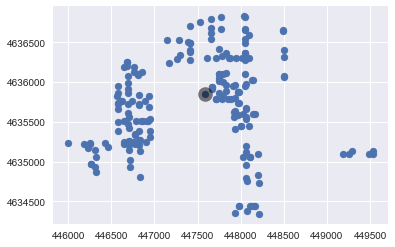

In [9]:
from sklearn.metrics import pairwise_distances_argmin_min # to find closest terminal to center

clustData = kData[0]
loc = clustData['locations']
dem = clustData['demand']
start_times =  [0] * len(demands)
end_times = [3600 * 24] * len(start_times)
labs = clustData['labels']
depot = labs.index(clustData['centralTerm']) # find the starting drop-off point
ca = clustData['cars']
print(depot)
print(clustData['centralTerm'])
print(labs[156])
print(len(loc))


X = np.array(zip([x[0] for x in loc],[x[1] for x in loc]))

plt.scatter(X[:, 0], X[:, 1])

print(loc[depot][0])
# print(ca)
# print(dem)
# centers = kmeans.cluster_centers_
plt.scatter(loc[depot][0], loc[depot][1], c='black', s=200, alpha=0.5)

# Run the optimization

## Output is in the following format:

Route PERSON ID Load CUMUALTIVE NUMBER OF TICKETS Time SECONDS FROM START -> NEXT NODE

In [10]:
# Establish running parameters of model
noEmps = 10
params = {'locations': loc, 'demands':dem, 'start_times':start_times, 'end_times':end_times, \
                 'num_vehicles':noEmps, 'search_time_limit': 30000,'horizon' : int(6.4 * 3600), \
                 'time_per_demand_unit' : 2*60, 'speed' : 1.34, 'VehicleCapacity' : 999999,\
                'depot' : depot, 'time_per_car_unit':1*60, 'labs':labs, 'cars' : ca, 'blockOverhead' : 2*60\
        }

In [15]:
solByCar, assignment = main(**params)

Total distance of all routes: 30317

Route 0: B201402 Load(0) Time(0) ->  B201402 Load(1) Time(527)


Cost(0..9223372036854775807)
Route 1: B201402 Load(0) Time(0) ->  B201402 Load(1) Time(527)


Cost(0..9223372036854775807)
Route 2: B201402 Load(0) Time(0) ->  B201402 Load(1) Time(527)


Cost(0..9223372036854775807)
Route 3: B201402 Load(0) Time(0) ->  B201402 Load(1) Time(527)


Cost(0..9223372036854775807)
Route 4: B201402 Load(0) Time(0) ->  B201402 Load(1) Time(527)


Cost(0..9223372036854775807)
Route 5: B201402 Load(0) Time(0) ->  B511504 Load(1) Time(1244) ->  B511506 Load(1) Time(1643) ->  B513505 Load(1) Time(2495) ->  B545505 Load(1) Time(3126) ->  B545516 Load(1) Time(3489) ->  B545510 Load(1) Time(4069) ->  B803903 Load(1) Time(4921) ->  B545509 Load(1) Time(5165) ->  B545513 Load(1) Time(5781) ->  B545506 Load(1) Time(6190) ->  B545508 Load(1) Time(6527) ->  B513508 Load(1) Time(7273) ->  B902501 Load(1) Time(8055) ->  B900503 Load(2) Time(9087) ->  B900501 Load(2) Time(9

In [33]:
solByCar

[(['B230407'], [0], ['0']),
 (['B230407',
   'B811904',
   'B815904',
   'B230406',
   'B239407',
   'B239408',
   'B239410',
   'B239409',
   'B356403',
   'B815902',
   'B611401',
   'B356407',
   'B200411',
   'B257408',
   'B385408',
   'B385403',
   'B260413',
   'B260412',
   'B260406',
   'B260415',
   'B260414',
   'B260402',
   'B260401',
   'B257418',
   'B257406',
   'B257405',
   'B257407',
   'B385404',
   'B385409',
   'B200413',
   'B200412',
   'B200408',
   'B200409',
   'B200407',
   'B200406',
   'B200401',
   'B200415',
   'B200414',
   'B200403',
   'B200405',
   'B200410',
   'B202403',
   'B202401',
   'B202404',
   'B240402',
   'B240403',
   'B356405',
   'B240405',
   'B240418',
   'B241412',
   'B241401',
   'B241402',
   'B241404',
   'B241407',
   'B241405',
   'B240401',
   'B815913',
   'B241410',
   'B241409',
   'B240404',
   'B240415',
   'B240414',
   'B240409',
   'B240408',
   'B239402',
   'B239403',
   'B239404',
   'B815903',
   'B815906',
   'B2

# How to fix redundant depot visit? create dummy depot staring point based on closest location with 0 ticket demand

# WARNING - DO NOT RUN THIS MORE THAN ONCE, OR IT WILL KEEP APPENDING NEW LIST ITEMS

In [9]:
def getData(cluster):
    clustData = kData[cluster]
    loc = clustData['locations']
    dem = clustData['demand']
    labs = clustData['labels']
    ca = clustData['cars']
    #TODO: implement the LAZ GARAGE IF CLUSTERID = N-CLUSTERS


    #begin appending of dummy start point
    loc.append(loc[labs.index(clustData['centralTerm'])])
    dem.append(0)
    ca.append(0)
    labs.append('starting by termial: ' + clustData['centralTerm'])
    depot = len(loc) - 1
    start_times =  [0] * len(demands)
    end_times = [3600 * 24] * len(start_times)
    return loc, dem, ca, labs, depot, start_times, end_times


   # The empUp function loops through number of enforcement agents until it finds the minimal viable needed employees per cluster

In [11]:

def empUp():    
    noEmps = 0
    solByCar = None
    while solByCar is None:
        try:
            noEmps += 1
            print("trying # of emplyoees : " + str(noEmps))
            solByCar, assignment = main(locations=loc, demands=dem, start_times=start_times, end_times=end_times, \
         num_vehicles=noEmps, search_time_limit = 30000,\
        horizon = int(6.4 * 3600), time_per_demand_unit = 3*60, speed = 1.34, VehicleCapacity = 999999,\
        depot = depot, time_per_car_unit=1*60, labs=labs, cars=ca, blockOverhead = 2 * 60)
        except:
             pass
    return solByCar, noEmps


# Now run the optimization for all clusters

In [12]:
for k in range(nClusters):
    print("Starting cluster {} of {}".format(k, nClusters))
    loc, dem, ca, labs, depot, start_times, end_times = getData(k)
    solution, noEmps = empUp()
    kData[k].update({'solution': solution, 'empsNeeded': noEmps})

Starting cluster 0 of 30
trying # of emplyoees : 1
No solution found.
trying # of emplyoees : 2
No solution found.
trying # of emplyoees : 3
No solution found.
trying # of emplyoees : 4
No solution found.
trying # of emplyoees : 5
Total distance of all routes: 31212

Route 0: starting by termial: B201402 Load(0) Time(0) ->  B201402 Load(0) Time(120) ->  B329407 Load(1) Time(831) ->  B329401 Load(1) Time(1383) ->  B828902 Load(2) Time(2288) ->  B329403 Load(2) Time(2571) ->  B201406 Load(3) Time(3599) ->  B201405 Load(3) Time(4288) ->  B828905 Load(3) Time(4635) ->  B828904 Load(3) Time(4757) ->  B201410 Load(3) Time(4965) ->  B201409 Load(3) Time(5434) ->  B201408 Load(3) Time(6041) ->  B329416 Load(4) Time(6935) ->  B329411 Load(4) Time(7116) ->  B328404 Load(4) Time(7606) ->  B328405 Load(4) Time(8148) ->  B330411 Load(4) Time(8881) ->  B330412 Load(4) Time(9386) ->  B343401 Load(4) Time(9978) ->  B343406 Load(4) Time(10284) ->  B343404 Load(4) Time(10975) ->  B529407 Load(4) Time(12

trying # of emplyoees : 2
No solution found.
trying # of emplyoees : 3
Total distance of all routes: 27202

Route 0: starting by termial: B394607 Load(0) Time(0) ->  B394607 Load(0) Time(120) ->  B394606 Load(0) Time(299) ->  B394615 Load(0) Time(757) ->  B394614 Load(0) Time(885) ->  B914602 Load(0) Time(2246) ->  B395604 Load(0) Time(2569) ->  B395603 Load(2) Time(3474) ->  B395602 Load(3) Time(4085) ->  B395601 Load(3) Time(4462) ->  B395609 Load(3) Time(4842) ->  B395608 Load(3) Time(5056) ->  B395607 Load(3) Time(5245) ->  B395606 Load(3) Time(5496) ->  B395605 Load(3) Time(5829) ->  B914601 Load(3) Time(6189) ->  B914603 Load(4) Time(6593) ->  B396601 Load(5) Time(7445) ->  B399616 Load(5) Time(9372) ->  B399615 Load(5) Time(9543) ->  B399613 Load(5) Time(9774) ->  B399612 Load(5) Time(9920) ->  B399610 Load(5) Time(10120) ->  B399609 Load(5) Time(10299) ->  B399611 Load(5) Time(10475) ->  B399608 Load(5) Time(10789) ->  B399607 Load(5) Time(11060) ->  B399606 Load(5) Time(11256)

No solution found.
trying # of emplyoees : 2
No solution found.
trying # of emplyoees : 3
No solution found.
trying # of emplyoees : 4
No solution found.
trying # of emplyoees : 5
No solution found.
trying # of emplyoees : 6
No solution found.
trying # of emplyoees : 7
No solution found.
trying # of emplyoees : 8
No solution found.
trying # of emplyoees : 9
Total distance of all routes: 44689

Route 0: starting by termial: B609201 Load(0) Time(0) ->  B609211 Load(0) Time(166) ->  B425209 Load(0) Time(1024) ->  B425230 Load(0) Time(1249) ->  B425225 Load(0) Time(1479) ->  B325202 Load(0) Time(1965) ->  B325219 Load(0) Time(2286) ->  B325223 Load(0) Time(3099) ->  B325210 Load(0) Time(3377) ->  B510204 Load(0) Time(4154) ->  B510203 Load(0) Time(4660) ->  B510202 Load(0) Time(5287) ->  B510201 Load(0) Time(5893) ->  B325217 Load(0) Time(7014) ->  B325211 Load(0) Time(7347) ->  B325216 Load(0) Time(7925) ->  B325224 Load(0) Time(8390) ->  B325215 Load(0) Time(8611) ->  B325213 Load(0) Tim


Cost(0..9223372036854775807)
Route 7: starting by termial: B609201 Load(0) Time(0) ->  B443222 Load(0) Time(244) ->  B443203 Load(0) Time(586) ->  B437221 Load(0) Time(908) ->  B437220 Load(0) Time(1206) ->  B437201 Load(0) Time(1430) ->  B446213 Load(0) Time(1974) ->  B446221 Load(0) Time(2220) ->  B446209 Load(0) Time(2471) ->  B446218 Load(0) Time(2996) ->  B446203 Load(0) Time(3289) ->  B446220 Load(0) Time(3864) ->  B446219 Load(0) Time(4081) ->  B446207 Load(0) Time(4382) ->  B446204 Load(0) Time(4888) ->  B446205 Load(0) Time(5246) ->  B446206 Load(0) Time(5607) ->  B446222 Load(0) Time(5939) ->  B446223 Load(0) Time(6170) ->  B447114 Load(0) Time(6499) ->  B447115 Load(0) Time(6984) ->  B447112 Load(0) Time(7499) ->  B447105 Load(0) Time(8002) ->  B447106 Load(0) Time(8356) ->  B447117 Load(0) Time(8721) ->  B447108 Load(0) Time(9422) ->  B447102 Load(0) Time(9777) ->  B447109 Load(0) Time(10320) ->  B448101 Load(0) Time(10926) ->  B448114 Load(0) Time(11590) ->  B448113 Load(

No solution found.
trying # of emplyoees : 3
Total distance of all routes: 22184

Route 0: starting by termial: B475101 Load(0) Time(0) ->  B487112 Load(0) Time(254) ->  B487114 Load(0) Time(669) ->  B487110 Load(0) Time(882) ->  B487115 Load(0) Time(1289) ->  B487129 Load(0) Time(1742) ->  B487116 Load(0) Time(2101) ->  B487120 Load(0) Time(2634) ->  B487127 Load(0) Time(2845) ->  B487125 Load(0) Time(3102) ->  B487122 Load(0) Time(3305) ->  B487130 Load(0) Time(3820) ->  B487124 Load(0) Time(4110) ->  B487102 Load(0) Time(4536) ->  B487101 Load(0) Time(4795) ->  B418106 Load(0) Time(5157) ->  B418107 Load(0) Time(5323) ->  B418112 Load(0) Time(5544) ->  B418104 Load(0) Time(5720) ->  B418105 Load(0) Time(6060) ->  B472108 Load(0) Time(6937) ->  B472127 Load(0) Time(7218) ->  B472109 Load(0) Time(7465) ->  B472115 Load(0) Time(7800) ->  B472110 Load(0) Time(8090) ->  B472114 Load(0) Time(8403) ->  B472113 Load(0) Time(8822) ->  B472112 Load(0) Time(9099) ->  B472111 Load(0) Time(9393)

No solution found.
trying # of emplyoees : 3
No solution found.
trying # of emplyoees : 4
Total distance of all routes: 25550

Route 0: starting by termial: B520127 Load(0) Time(0) ->  B500111 Load(0) Time(629) ->  B500110 Load(0) Time(877) ->  B501112 Load(0) Time(1482) ->  B501110 Load(0) Time(1838) ->  B501109 Load(0) Time(2013) ->  B501104 Load(0) Time(2279) ->  B501108 Load(0) Time(2574) ->  B501105 Load(0) Time(2903) ->  B501106 Load(0) Time(3407) ->  B501107 Load(0) Time(3876) ->  B502107 Load(0) Time(4384) ->  B502101 Load(0) Time(4721) ->  B502102 Load(0) Time(5247) ->  B502106 Load(0) Time(5549) ->  B502103 Load(0) Time(5858) ->  B502104 Load(0) Time(6273) ->  B502108 Load(0) Time(6716) ->  B503107 Load(0) Time(7033) ->  B503101 Load(0) Time(7232) ->  B503106 Load(0) Time(7646) ->  B503102 Load(0) Time(8008) ->  B503105 Load(0) Time(8477) ->  B503103 Load(0) Time(8981) ->  B503104 Load(0) Time(9315) ->  B503108 Load(0) Time(9664) ->  B503109 Load(0) Time(9832) ->  B524101 Loa

Route 1: starting by termial: B269604 Load(0) Time(0) ->  B269604 Load(0) Time(120) ->  B270612 Load(0) Time(385) ->  B270613 Load(0) Time(807) ->  B270614 Load(0) Time(1117) ->  B269602 Load(0) Time(1541) ->  B274605 Load(0) Time(3027) ->  B274604 Load(0) Time(3272) ->  B274607 Load(0) Time(3542) ->  B274602 Load(0) Time(3897) ->  B274603 Load(0) Time(4335) ->  B274606 Load(0) Time(4649) ->  B274601 Load(0) Time(4925) ->  B274608 Load(0) Time(5147) ->  B273610 Load(0) Time(6927) ->  B273601 Load(0) Time(7101) ->  B273608 Load(0) Time(7493) ->  B273602 Load(0) Time(7902) ->  B273604 Load(1) Time(8731) ->  B273605 Load(1) Time(8905) ->  B273611 Load(1) Time(9216) ->  B273607 Load(1) Time(9341) ->  B272614 Load(1) Time(9574) ->  B271601 Load(1) Time(9956) ->  B272613 Load(1) Time(10449) ->  B272612 Load(1) Time(10603) ->  B271602 Load(1) Time(10809) ->  B271612 Load(1) Time(10994) ->  B271604 Load(1) Time(11212) ->  B272611 Load(1) Time(11576) ->  B272610 Load(1) Time(11982) ->  B272609 

Total distance of all routes: 20052

Route 0: starting by termial: B265603 Load(0) Time(0) ->  B265603 Load(0) Time(120) ->  B265618 Load(0) Time(335) ->  B265611 Load(0) Time(504) ->  B265613 Load(0) Time(766) ->  B265615 Load(0) Time(1118) ->  B265601 Load(0) Time(1391) ->  B419606 Load(0) Time(5173) ->  B419604 Load(0) Time(5492) ->  B419602 Load(1) Time(6015) ->  B419603 Load(1) Time(6483) ->  B419601 Load(1) Time(6937) ->  B265602 Load(1) Time(10857) ->  B265614 Load(1) Time(11076) ->  L169801 Load(1) Time(11244) ->  B265612 Load(1) Time(12232) ->  starting by termial: B265603 Load(1) Time(12656)


Cost(0..9223372036854775807)
Route 1: starting by termial: B265603 Load(0) Time(0) ->  B265609 Load(0) Time(136) ->  B206604 Load(0) Time(1568) ->  B206605 Load(0) Time(1928) ->  B206603 Load(0) Time(2277) ->  B206602 Load(0) Time(2502) ->  B206606 Load(0) Time(2854) ->  B206601 Load(0) Time(3069) ->  B206607 Load(1) Time(3622) ->  L195801 Load(1) Time(5111) ->  B266621 Load(1) Time(834

No solution found.
trying # of emplyoees : 2
No solution found.
trying # of emplyoees : 3
Total distance of all routes: 18524

Route 0: starting by termial: B380609 Load(0) Time(0) ->  B380608 Load(0) Time(146) ->  B616614 Load(0) Time(2040) ->  B616613 Load(0) Time(2257) ->  B616607 Load(0) Time(2641) ->  B616605 Load(0) Time(2792) ->  B616603 Load(0) Time(3173) ->  B616609 Load(0) Time(3319) ->  B616601 Load(0) Time(3507) ->  B616611 Load(0) Time(3719) ->  B636605 Load(0) Time(4540) ->  B636604 Load(0) Time(4908) ->  B636603 Load(0) Time(5385) ->  B636606 Load(1) Time(5941) ->  B636602 Load(2) Time(6537) ->  B636607 Load(3) Time(7045) ->  B636601 Load(3) Time(7499) ->  B636608 Load(4) Time(8031) ->  B616615 Load(4) Time(9031) ->  B616620 Load(5) Time(9641) ->  B616616 Load(6) Time(10167) ->  B616618 Load(8) Time(10946) ->  starting by termial: B380609 Load(9) Time(12442)


Cost(0..9223372036854775807)
Route 1: starting by termial: B380609 Load(0) Time(0) ->  B264605 Load(0) Time(897)

No solution found.
trying # of emplyoees : 3
No solution found.
trying # of emplyoees : 4
Total distance of all routes: 24316

Route 0: starting by termial: B467106 Load(0) Time(0) ->  B920107 Load(0) Time(488) ->  B920106 Load(0) Time(1156) ->  B920105 Load(0) Time(1785) ->  B468101 Load(0) Time(2178) ->  B468118 Load(0) Time(2529) ->  B468102 Load(0) Time(2916) ->  B468117 Load(0) Time(3344) ->  B468116 Load(0) Time(3790) ->  B468115 Load(0) Time(3973) ->  B468104 Load(0) Time(4182) ->  B468114 Load(0) Time(4524) ->  B468105 Load(0) Time(4964) ->  B468113 Load(0) Time(5472) ->  B468107 Load(0) Time(5832) ->  B468108 Load(0) Time(6174) ->  B468110 Load(0) Time(6737) ->  B467109 Load(0) Time(7400) ->  B467112 Load(0) Time(7829) ->  B467114 Load(0) Time(8261) ->  B467115 Load(0) Time(8798) ->  B467124 Load(0) Time(9110) ->  B465114 Load(0) Time(9752) ->  B465112 Load(0) Time(10006) ->  B450109 Load(0) Time(10715) ->  B450103 Load(0) Time(11384) ->  B450107 Load(0) Time(12252) ->  B45010

trying # of emplyoees : 1
Total distance of all routes: 8180

Route 0: starting by termial: B342303 Load(0) Time(0) ->  B342302 Load(0) Time(222) ->  B342301 Load(0) Time(654) ->  B721315 Load(0) Time(901) ->  B721312 Load(0) Time(1093) ->  B721311 Load(0) Time(1513) ->  B721318 Load(0) Time(1885) ->  B721307 Load(0) Time(2116) ->  B721304 Load(0) Time(2483) ->  B721301 Load(0) Time(2698) ->  B340102 Load(0) Time(2941) ->  B340117 Load(0) Time(3107) ->  B340105 Load(0) Time(3331) ->  B340106 Load(0) Time(3600) ->  B340108 Load(0) Time(3904) ->  B340109 Load(0) Time(4080) ->  B340114 Load(0) Time(4525) ->  B340116 Load(0) Time(4769) ->  B432112 Load(0) Time(7240) ->  B432104 Load(0) Time(7492) ->  B432108 Load(0) Time(7900) ->  B432109 Load(0) Time(8183) ->  B432110 Load(0) Time(8387) ->  B432101 Load(0) Time(8757) ->  B432107 Load(0) Time(9485) ->  B432106 Load(0) Time(9659) ->  B341301 Load(0) Time(11197) ->  B342310 Load(0) Time(11605) ->  B342309 Load(0) Time(11944) ->  B342312 Load

No solution found.
trying # of emplyoees : 3
Total distance of all routes: 23200

Route 0: starting by termial: B317110 Load(0) Time(0) ->  B316118 Load(0) Time(1183) ->  B318101 Load(1) Time(2716) ->  B318110 Load(1) Time(3040) ->  B318107 Load(2) Time(3814) ->  B318111 Load(3) Time(5307) ->  B318112 Load(3) Time(5457) ->  B318106 Load(3) Time(6394) ->  B318105 Load(3) Time(6760) ->  B318104 Load(3) Time(7203) ->  B318102 Load(3) Time(7428) ->  B318103 Load(3) Time(7621) ->  B317115 Load(3) Time(9661) ->  B317109 Load(3) Time(10042) ->  starting by termial: B317110 Load(3) Time(10441)


Cost(0..9223372036854775807)
Route 1: starting by termial: B317110 Load(0) Time(0) ->  B317116 Load(0) Time(227) ->  B317105 Load(0) Time(977) ->  B317106 Load(0) Time(1167) ->  B317118 Load(0) Time(1457) ->  B317101 Load(1) Time(2044) ->  B317102 Load(1) Time(2357) ->  B315116 Load(1) Time(2857) ->  B315117 Load(1) Time(3045) ->  B315106 Load(1) Time(3336) ->  B315109 Load(1) Time(3642) ->  B461129 Lo

Total distance of all routes: 11029

Route 0: starting by termial: B371603 Load(0) Time(0) ->  B366610 Load(0) Time(654) ->  B366611 Load(0) Time(899) ->  B366612 Load(0) Time(1231) ->  B366613 Load(0) Time(1580) ->  B366614 Load(0) Time(2089) ->  B365604 Load(0) Time(2640) ->  B365608 Load(0) Time(2930) ->  B365603 Load(0) Time(3170) ->  B365605 Load(0) Time(3630) ->  B365606 Load(0) Time(4196) ->  B365602 Load(0) Time(4572) ->  B365609 Load(0) Time(4998) ->  B365601 Load(0) Time(5203) ->  B359621 Load(1) Time(6272) ->  B365607 Load(1) Time(7279) ->  B366615 Load(1) Time(7543) ->  B366601 Load(2) Time(8553) ->  B366604 Load(3) Time(9463) ->  B366605 Load(3) Time(9756) ->  B366606 Load(3) Time(10068) ->  B366609 Load(3) Time(10563) ->  B366607 Load(3) Time(11120) ->  B366608 Load(3) Time(11406) ->  starting by termial: B371603 Load(3) Time(12130)


Cost(0..9223372036854775807)
Route 1: starting by termial: B371603 Load(0) Time(0) ->  B371603 Load(0) Time(120) ->  B371620 Load(0) Time(5

Cost(0..9223372036854775807)
Route 2: starting by termial: B260406 Load(0) Time(0) ->  B261402 Load(0) Time(304) ->  B261401 Load(0) Time(677) ->  B261406 Load(0) Time(1009) ->  B257410 Load(0) Time(1378) ->  B257403 Load(0) Time(1663) ->  B517511 Load(0) Time(2181) ->  B801907 Load(0) Time(2399) ->  B517501 Load(0) Time(2519) ->  B527514 Load(0) Time(2905) ->  B517503 Load(0) Time(3297) ->  B517502 Load(0) Time(3529) ->  B528505 Load(0) Time(4000) ->  B512513 Load(0) Time(4343) ->  B517520 Load(0) Time(4841) ->  B517504 Load(0) Time(5003) ->  B528504 Load(0) Time(5562) ->  B517506 Load(0) Time(5872) ->  B527502 Load(0) Time(6277) ->  B527503 Load(0) Time(6657) ->  B528503 Load(0) Time(7061) ->  B527505 Load(0) Time(7294) ->  B802907 Load(0) Time(7773) ->  B512512 Load(1) Time(8152) ->  B802902 Load(1) Time(8520) ->  B512502 Load(1) Time(8662) ->  B527506 Load(1) Time(9060) ->  B527519 Load(1) Time(9349) ->  B527508 Load(1) Time(9726) ->  B528507 Load(1) Time(10172) ->  B527510 Load(1)

# Write the solutions to file

In [ ]:
import pickle
import datetime

now = datetime.datetime.now()

filename = "solutionFile" + now.strftime("%Y-%m-%d %H:%M") + ".pickle"
with open(filename, 'wb') as handle:
    pickle.dump(kData, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(filename + " saved")

In [13]:


bid = []
time = []
personID = 1
people = []
clus = []
for k in range(nClusters):
    for person in kData[k]['solution']:
        bid.extend(person[0])
        time.extend(person[2])
        pp = [personID] * len(person[0])
        people.extend(pp)
        personID += 1
        clusta = [k] * len(person[0])
        clus.extend(clusta)

In [17]:
finalDFDict = {'Cluster ID': clus, 'Route ID': people, 'Block ID': bid, 'Expected Time': time}

finalData = pd.DataFrame.from_dict(finalDFDict)

filename = "routeFile" + now.strftime("%Y-%m-%d %H:%M") + ".csv"

finalData.to_csv(filename)

finalData.head()

,Block ID,Cluster ID,Expected Time,Route ID
0,starting by termial: B201402,0,0,1
1,B201402,0,120,1
2,B329407,0,831,1
3,B329401,0,1383,1
4,B828902,0,2288,1


In [15]:
finalData.groupby('Cluster ID')['Route ID'].nunique()


Cluster ID
0      5
1      4
2      3
3      2
4      2
5      9
6     10
7      3
8      3
9      4
10     2
11     2
12     5
13     2
14     4
15     1
16     3
17     1
18     4
19     4
20     1
21     1
22     1
23     4
24     3
25     3
26     2
27     4
28     5
29     1
Name: Route ID, dtype: int64